In [84]:
import q1_pendulum as myODE
import numpy as np
import scipy
import matplotlib.pyplot as plt
import datetime

'''
Set hbar ^ 2 / m as 1 and E is in the unit of hbar ^ 2 / m
e ^ 2 / 4\pi \epsilon_0 is also 1
'''


def V1(r):
    return -1 / r


def V2(r):
    r0 = r / 0.4
    v1 = -3 / r * scipy.special.erf(r0 / np.sqrt(2))
    v2 = np.exp(-r0 ** 2 / 2) * (-14.0093922 + 9.5099073 * r0**2 -
                                                  1.7532723 * r0**4 + 0.0834586 * r0**6)
    return v1 + v2


def radial_Schrodinger(y, r, V, E, l):
    dy1 = y[1]
    dy2 = (-2 * E + 2 * V(r) + l * (l + 1) / r ** 2) * y[0]
    return np.array([dy1, dy2])


def plot_u_inf_to_E(res, Es, l=0, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        ax.plot(Es, np.zeros(Es.shape[0]), ls=':', c='gray', alpha=0.5)
        ax.set_xlabel('energy')
        ax.set_ylabel('$\psi_{\infty}$')

    ax.plot(Es, res, label=label)
    ax.legend()
    fig = ax.get_figure()
    ax.set_ylim(-1, 1)
    # plt.show()
    return fig, ax


def solve_potential_brutal(l, V=V1):
    # try different energy (eigenvalue)
    res = np.array([])
    Es = np.linspace(-4, 0, 100)
    for E in Es:
        res = np.append(res, get_psi_inf(E, l, r_inf=10, V=V))
    fig, ax = plot_u_inf_to_E(res, Es, l, 'inf = 10')

    for r_inf in [50, 100]:
        res = np.array([])
        for E in Es:
            res = np.append(res, get_psi_inf(E, l, r_inf=r_inf, V=V))
        fig, ax = plot_u_inf_to_E(res, Es, l=l, label=f'inf = {r_inf}', ax=ax)
    # plt.show()
    fig.savefig(f'q2_uinf_to_energy_l={l}_pot2.png')
    # TODO: try more l


def solve_potential_bisec(el, er, V, l=0, r_inf=100, rev=False):
    if not rev:
        psi_l = get_psi_inf(el, l=l, r_inf=r_inf, V=V)
        psi_r = get_psi_inf(er, l=l, r_inf=r_inf, V=V)
    else:
        psi_l = get_psi_zero(el, l=l, r_inf=r_inf, V=V)
        psi_r = get_psi_zero(er, l=l, r_inf=r_inf, V=V)
    print('init:', psi_l, psi_r)
    assert (psi_l < 0 and psi_r > 0) or (
        psi_l > 0 and psi_r < 0), 'bad init sect'
    psi_mid = 1
    while np.abs(el - er) > 1e-6 and np.abs(psi_mid) > 1e-5:
        e_mid = (el + er) / 2
        if not rev:
            psi_mid, solver = get_psi_inf(
                e_mid, l, r_inf, V=V, ret_solver=True)
        else:
            psi_mid, solver = get_psi_zero(
                e_mid, l, r_inf, V=V, ret_solver=True)
        if (psi_mid < 0 and psi_l < 0) or (psi_mid > 0 and psi_l > 0):
            el = e_mid
        else:
            er = e_mid
        print(e_mid, psi_mid)
    # plot_psi([solver])
    # plt.show()
    return e_mid, solver


def solve_potential_1_intersec(el, er):
    psi_l = get_psi_inf(el, 0, 100)
    psi_r = get_psi_inf(er, 0, 100)
    print('init:', psi_l, psi_r)
    assert (psi_l < 0 and psi_r > 0) or (
        psi_l > 0 and psi_r < 0), 'bad init sect'
    while np.abs(el - er) > 1e-5:
        e_next = (psi_r * el - psi_l * er) / (psi_r - psi_l)
        psi_next = get_psi_inf(e_next, 0, 100)
        if (psi_next < 0 and psi_l < 0) or (psi_next > 0 and psi_l > 0):
            el = e_next
        else:
            er = e_next

    return e_next


def get_psi_zero(E, l, r_inf=100., V=V1, ret_solver=False):
    def f(x, y):
        return radial_Schrodinger(y, x, V, E, l)
    # Is the boundary condition at r = 0 determined by potential???
    # arbitrary y'_0: take 1
    solver = myODE.ODE(r_inf, np.array([0, 1], dtype=float), f)
    solver.solve_RK4(1e-10, r_step, rev=True)
    # plt.plot(solver.get_res_t(), solver.get_res_theta())
    # plt.show()
    if ret_solver:
        return solver.get_res_theta()[-1], solver
    return solver.get_res_theta()[-1]


def get_psi_inf(E, l, r_inf=100, V=V1, ret_solver=False):
    def f(x, y):
        return radial_Schrodinger(y, x, V, E, l)
    # Is the boundary condition at r = 0 determined by potential???
    # arbitrary y'_0: take 1
    solver = myODE.ODE(1e-10, np.array([0, 1], dtype=float), f)
    solver.solve_RK4(r_inf, r_step)
    # plt.plot(solver.get_res_t(), solver.get_res_theta())
    # plt.show()
    if ret_solver:
        return solver.get_res_theta()[-1], solver
    return solver.get_res_theta()[-1]


def plot_psi(solvers, labels=None, cs=None, scales=None, lses=None):
    assert labels is not None
    fig, ax = plt.subplots(1, 1)
    for solver, label, c, scale, ls in zip(solvers, labels, cs, scales, lses):
        ax.plot(solver.get_res_t(), solver.get_res_theta() * scale,
                label=label, c=c, ls=ls)
    ax.set_ylim(-10, 10)
    ax.set_xlim(-1, 40)
    ax.set_xlabel('r / a.u.')
    ax.set_ylabel('psi / a.u.')
    ax.legend()
    plt.show()
    return fig, ax


In [3]:
r_step = 1e-2
# solve_potential_brutal(0, V=V2)
# solve_potential_brutal(1, V=V2)
# solve_potential_brutal(2, V=V2)

e1, solver1 = solve_potential_bisec(-0.6, -0.4, V1, l=0, r_inf=100.)
e2, solver2 = solve_potential_bisec(-0.2, -0.1, V1, l=0, r_inf=100.)
e3, solver3 = solve_potential_bisec(-0.06, -0.05, V1, l=0, r_inf=100.)

e1_rev, solver1_rev = solve_potential_bisec(
    -0.6, -0.4, V1, l=0, r_inf=100., rev=True)
e2_rev, solver2_rev = solve_potential_bisec(
    -0.2, -0.1, V1, l=0, r_inf=100., rev=True)
e3_rev, solver3_rev = solve_potential_bisec(
    -0.06, -0.05, V1, l=0, r_inf=100., rev=True)
print(e1, e2, e3, e1_rev, e2_rev, e3_rev)



this function takes 0.29166722297668457 seconds
this function takes 0.27959418296813965 seconds
init: 1.1524206458864804e+44 -1.3117265338008253e+35
this function takes 0.34899091720581055 seconds
-0.5 2.5098588269162674e+32
this function takes 0.2776017189025879 seconds
-0.45 -1.7628620246324236e+37
this function takes 0.2521371841430664 seconds
-0.475 -1.2720350535182853e+38
this function takes 0.26453638076782227 seconds
-0.4875 -2.3480437754345963e+38
this function takes 0.2609975337982178 seconds
-0.49375 -2.2404969538312678e+38
this function takes 0.2784435749053955 seconds
-0.496875 -1.5450006836446725e+38
this function takes 0.26069140434265137 seconds
-0.4984375 -9.06833874202513e+37
this function takes 0.27977991104125977 seconds
-0.49921875 -4.912101540153445e+37
this function takes 0.2635173797607422 seconds
-0.499609375 -2.5562869018146433e+37
this function takes 0.3690042495727539 seconds
-0.4998046875 -1.3039468994436768e+37
this function takes 0.2580530643463135 seconds

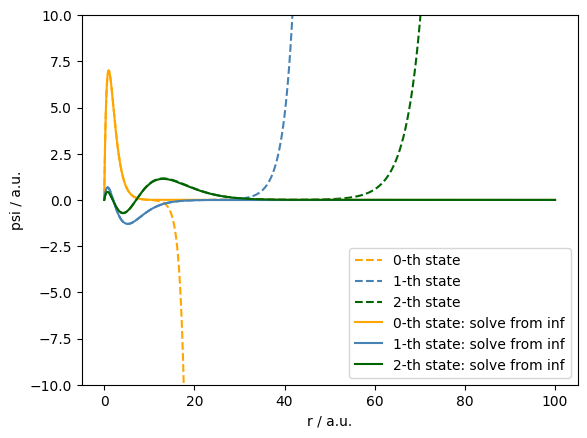

In [17]:
labels = [f'{i}-th state' for i in range(3)] + \
    [f'{i}-th state: solve from inf' for i in range(3)]
fig, ax = plot_psi([solver1, solver2, solver3, solver1_rev, solver2_rev,
                    solver3_rev], labels=labels, cs=['orange', 'steelblue', 'darkgreen'] * 2, scales=[19, 2.1, 1.4] + [-1.4e-40, 1.9e-18, -1.87e-10], lses=['--'] * 3 + ['-'] * 3)
fig.savefig('pot_1.png')



In [18]:
r_step = 1e-2

e1_pot2, solver1 = solve_potential_bisec(-4, -5, V2, l=0, r_inf=100.)
e2_pot2, solver2 = solve_potential_bisec(-1.2, -0.9, V2, l=1, r_inf=100.)
e3_pot2, solver3 = solve_potential_bisec(-1.2, -0.9, V2, l=0, r_inf=100.)

e1_rev_pot2, solver1_rev = solve_potential_bisec(
    -4, -5, V2, l=0, r_inf=100., rev=True)
e2_rev_pot2, solver2_rev = solve_potential_bisec(
    -1.2, -0.9, V2, l=1, r_inf=100., rev=True)
e3_rev_pot2, solver3_rev = solve_potential_bisec(
    -1.2, -0.9, V2, l=0, r_inf=100., rev=True)
print(e1_pot2, e2_pot2, e3_pot2, e1_rev_pot2, e2_rev_pot2, e3_rev_pot2)

this function takes 0.5877106189727783 seconds
this function takes 0.4419875144958496 seconds
init: -1.244567013225555e+118 6.775423374978018e+132
this function takes 0.45031213760375977 seconds
-4.5 3.9561906362055886e+124
this function takes 0.4589827060699463 seconds
-4.25 -3.8137468371803154e+121
this function takes 0.44664621353149414 seconds
-4.375 -1.1318127544891955e+123
this function takes 0.561429500579834 seconds
-4.4375 -2.3729880578074516e+123
this function takes 0.4454371929168701 seconds
-4.46875 3.464464725579537e+123
this function takes 0.4860191345214844 seconds
-4.453125 -9.952284247289106e+122
this function takes 0.48172497749328613 seconds
-4.4609375 6.813931309361485e+122
this function takes 0.4466540813446045 seconds
-4.45703125 -2.6955299813225083e+122
this function takes 0.46362876892089844 seconds
-4.458984375 1.748982835530832e+122
this function takes 0.47441816329956055 seconds
-4.4580078125 -5.4705231123300215e+121
this function takes 0.4747591018676758 sec

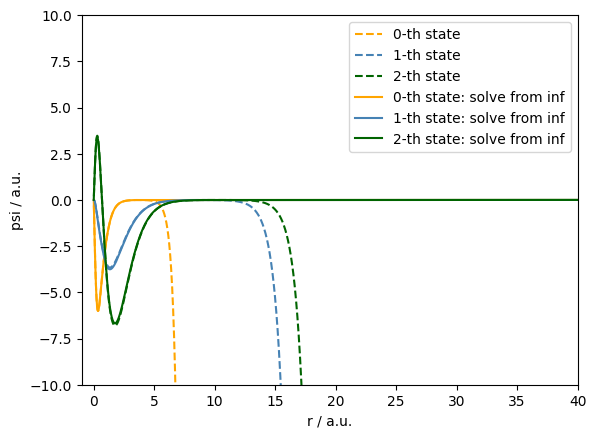

In [85]:
labels = [f'{i}-th state' for i in range(3)] + \
    [f'{i}-th state: solve from inf' for i in range(3)]

solvers = [solver1, solver2, solver3, solver1_rev, solver2_rev,
                    solver3_rev]
scales = list(5 / np.array([np.max(np.abs((sol.get_res_theta()[:]))) for sol in solvers]))
fig, ax = plot_psi(solvers, labels=labels, cs=['orange', 'steelblue', 'darkgreen'] * 2, scales=[-30, -6e-2, 20, 6e-126, 4e-60, 2e-59], lses=['--'] * 3 + ['-'] * 3)
fig.savefig('pot_2.png')


In [86]:
print('eigenvalues (energies) of H, starting from r = 0:', e1, e2, e3, '\nstarting from r = 100.0:', e1_rev, e2_rev, e3_rev)
print('eigenvalues (energies) of Li, starting from r = 0:', e1_pot2, e2_pot2, e3_pot2, '\nstarting from r = 100.0:', e1_rev_pot2, e2_rev_pot2, e3_rev_pot2)

eigenvalues (energies) of H, starting from r = 0: -0.4999992370605469 -0.12499923706054687 -0.05555603027343749 
starting from r = 100.0: -0.4999992370605469 -0.12499923706054687 -0.05555603027343749
eigenvalues (energies) of Li, starting from r = 0: -4.458247184753418 -1.122279167175293 -1.1154321670532226 
starting from r = 100.0: -4.458247184753418 -1.122279167175293 -1.1154321670532226
